In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import burst_detector as bd
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.profiler import profile, record_function, ProfilerActivity
from sklearn.decomposition import PCA

In [2]:
n_chan = 385

ks_dir = "../data/rec_bank0_dense_g0/KS2.5/catgt_rec_bank0_dense_g0/rec_bank0_dense_g0_imec0/imec0_ks2/"

times = np.load(os.path.join(ks_dir, "spike_times.npy")).flatten()
clusters = np.load(os.path.join(ks_dir, "spike_clusters.npy")).flatten()

counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv(os.path.join(ks_dir, "cluster_group.tsv"), sep="\t", index_col=False)
times_multi = bd.find_times_multi(times, clusters, np.arange(clusters.max()+1))

channel_pos = np.load(os.path.join(ks_dir, "channel_positions.npy"))
channel_map = np.load(os.path.join(ks_dir, "channel_map.npy")).flatten()
mean_wf = np.load(os.path.join(ks_dir, "mean_waveforms.npy"))
channel_shanks = (channel_pos[:,0]/250).astype("int")
templates = np.load(os.path.join(ks_dir, "templates.npy"))

# load raw data
rawData = np.memmap("C:/Users/Harris_Lab/Projects/burst-detector/data/rec_bank0_dense_g0/KS2.5/catgt_rec_bank0_dense_g0/rec_bank0_dense_g0_imec0/rec_bank0_dense_g0_tcat.imec0.ap.bin", dtype='int16', mode='r')
data = np.reshape(rawData, (int(rawData.size/n_chan), n_chan))

In [110]:
def get_closest_channels(channel_positions, channel_index, n=None):
    """Get the channels closest to a given channel on the probe."""
    x = channel_positions[:, 0]
    y = channel_positions[:, 1]
    x0, y0 = channel_positions[channel_index]
    d = (x - x0) ** 2 + (y - y0) ** 2
    out = np.argsort(d)
    if n:
        out = out[:n]
    return out

In [111]:
def find_best_channels(template):
    amplitude_threshold = 0
    
    amplitude = template.max(axis=1) - template.min(axis=1)
    best_channel = min(np.argmax(amplitude), 382)
    max_amp = amplitude[best_channel]
    
    peak_channels = np.nonzero(amplitude >= amplitude_threshold * max_amp)[0]
    
    close_channels = get_closest_channels(channel_pos, best_channel, 8)

    shank = channel_shanks[best_channel]
    channels_on_shank = np.nonzero(channel_shanks == shank)[0]
    close_channels = np.intersect1d(close_channels, channels_on_shank)
    channel_ids = np.intersect1d(close_channels, peak_channels)
    
    return channel_ids, best_channel

In [112]:
def get_dists(channel_positions, ref_chan, target_chan):
    x = channel_positions[:, 0]
    y = channel_positions[:, 1]
    x0, y0 = channel_positions[ref_chan]
    d = (x - x0) ** 2 + (y - y0) ** 2
    # d[y < y0] *= -1
    return d[target_chan]

In [113]:
chans = {}

for i in range(mean_wf.shape[0]):
    if i in counts:
        chs, peak = find_best_channels(mean_wf[i])
        dists = get_dists(channel_pos, peak, chs)
        chans[i] = chs[np.argsort(dists)].tolist()

In [114]:
file_names = []
cl_ids = []

pre_samples = 10
post_samples = 30

max_spikes = 2000
min_spikes = 100


In [115]:
tot = 0
for i in range(clusters.max()+1):
    if (i in counts) and (counts[i] > min_spikes) and (labels.loc[labels['cluster_id']==i, 'group'].item() == 'good'):
        cl_times = times_multi[i].astype("int32")
        
        # cap number of spikes
        if (max_spikes < cl_times.shape[0]):
            np.random.shuffle(cl_times)
            cl_times = cl_times[:max_spikes]
            
        # save spikes to file and add to annotations
        for j in range(cl_times.shape[0]):
            file_names.append("cl%d_spk%d.npy" % (i, j))
            cl_ids.append(i)
            
            spike = data[cl_times[j]-pre_samples:cl_times[j]+post_samples, chans[i]].T
            spike = np.nan_to_num(spike)
            out_name = "./data/bijan_spikes/cl%d_spk%d.npy" % (i, j)
            
            np.save(out_name, spike)

In [116]:
df = pd.DataFrame({'file':file_names, 'cl':cl_ids}, index=None)
df.to_csv("./data/bijan_spikes/labels.csv", header=False, index=False)

In [4]:
class SpikeDataset(Dataset):
    def __init__(self, annotations_file, spk_dir, transform=None, target_transform=None):
        self.spk_labels = pd.read_csv(annotations_file, header=None)
        self.spk_dir = spk_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.spk_labels)

    def __getitem__(self, idx):
        spk_path = os.path.join(self.spk_dir, self.spk_labels.iloc[idx, 0])
        spk = np.load(spk_path).astype('float32')
        label = self.spk_labels.iloc[idx, 1]
        if self.transform:
            spk = self.transform(spk)
        if self.target_transform:
            label = self.target_transform(label)
        return spk, label

In [5]:
spk_data = SpikeDataset("./data/bijan_spikes/labels.csv","./data/bijan_spikes/", ToTensor())

In [11]:
BATCH_SIZE = 128

labels = spk_data.spk_labels.iloc[:, 1]

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(spk_data)),
    labels,
    stratify=labels,
    test_size=0.2,
    random_state=42
)

# generate subset based on indices
train_split = Subset(spk_data, train_indices)
test_split = Subset(spk_data, test_indices)

# create batches
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)

## Net Definition

In [136]:
"""
A Convolutional Variational Autoencoder
"""
class CN_VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=256*1*40, zDim=12):
        super(CN_VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 64, (3,1), padding='same')
        self.encBN1 = nn.BatchNorm2d(64)
        self.encPool1 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encConv2 = nn.Conv2d(64, 128, (3,1), padding='same')
        self.encBN2 = nn.BatchNorm2d(128)
        self.encPool2 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encConv3 = nn.Conv2d(128, 256, (3,1), padding='same')
        self.encBN3 = nn.BatchNorm2d(256)
        self.encPool3 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decBN1 = nn.BatchNorm2d(256)
        
        self.decUpSamp1 = nn.Upsample((2,40))
        self.decConv1 = nn.ConvTranspose2d(256, 128, (3,1), padding=(1,0))
        self.decBN2 = nn.BatchNorm2d(128)
        
        self.decUpSamp2 = nn.Upsample((4,40))
        self.decConv2 = nn.ConvTranspose2d(128, 64, (3,1), padding=(1,0))
        self.decBN3 = nn.BatchNorm2d(64)
        
        self.decUpSamp3 = nn.Upsample((8,40))
        self.decConv3 = nn.ConvTranspose2d(64, imgChannels, (3,1), padding=(1,0))


    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encBN1(self.encConv1(x)))
        x, self.encInd1 = self.encPool1(x)
        
        x = F.relu(self.encBN2(self.encConv2(x)))
        x, self.encInd2 = self.encPool2(x)
        
        x = F.relu(self.encBN3(self.encConv3(x)))
        x, self.encInd3 = self.encPool3(x)
        
        x = x.view(-1, 256*1*40)
        
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = self.decFC1(z)
        x = x.view(-1, 256, 1, 40)
        x = F.relu(self.decBN1(x))
        x = self.decUpSamp1(x)
 
        x = F.relu(self.decBN2(self.decConv1(x)))
        x = self.decUpSamp2(x)
        
        x = F.relu(self.decBN3(self.decConv2(x)))
        x = self.decUpSamp3(x)
        x = self.decConv3(x)
        
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [7]:
"""
A Convolutional Autoencoder
"""
class CN_AE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=256*1*40, zDim=15):
        super(CN_AE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 64, (3,1), padding='same')
        self.encBN1 = nn.BatchNorm2d(64)
        self.encPool1 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encConv2 = nn.Conv2d(64, 128, (3,1), padding='same')
        self.encBN2 = nn.BatchNorm2d(128)
        self.encPool2 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encConv3 = nn.Conv2d(128, 256, (3,1), padding='same')
        self.encBN3 = nn.BatchNorm2d(256)
        self.encPool3 = nn.MaxPool2d((2,1), return_indices=True)
        
        self.encFC1 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decBN1 = nn.BatchNorm2d(256)
        
        self.decUpSamp1 = nn.Upsample((2,40))
        self.decConv1 = nn.ConvTranspose2d(256, 128, (3,1), padding=(1,0))
        self.decBN2 = nn.BatchNorm2d(128)
        
        self.decUpSamp2 = nn.Upsample((4,40))
        self.decConv2 = nn.ConvTranspose2d(128, 64, (3,1), padding=(1,0))
        self.decBN3 = nn.BatchNorm2d(64)
        
        self.decUpSamp3 = nn.Upsample((8,40))
        self.decConv3 = nn.ConvTranspose2d(64, imgChannels, (3,1), padding=(1,0))


    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encBN1(self.encConv1(x)))
        x, self.encInd1 = self.encPool1(x)
        
        x = F.relu(self.encBN2(self.encConv2(x)))
        x, self.encInd2 = self.encPool2(x)
        
        x = F.relu(self.encBN3(self.encConv3(x)))
        x, self.encInd3 = self.encPool3(x)
        
        x = x.view(-1, 256*1*40)
        
        x = self.encFC1(x)
        
        return x

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = self.decFC1(z)
        x = x.view(-1, 256, 1, 40)
        x = F.relu(self.decBN1(x))
        x = self.decUpSamp1(x)
 
        x = F.relu(self.decBN2(self.decConv1(x)))
        x = self.decUpSamp2(x)
        
        x = F.relu(self.decBN3(self.decConv2(x)))
        x = self.decUpSamp3(x)
        x = self.decConv3(x)
        
        return x

    def forward(self, x):

        # The entire pipeline of the AE: encoder -> decoder
        z = self.encoder(x)
        out = self.decoder(z)
        
        return out

In [8]:
"""
A Linear Convolutional Autoencoder
"""
class Lin_AE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=256*1*40, zDim=15):
        super(Lin_AE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 64, (3,1), padding='same')
        self.encLin1 = nn.Linear(64*8*40, 64*4*40)
        
        self.encConv2 = nn.Conv2d(64, 128, (3,1), padding='same')
        self.encLin2 = nn.Linear(128*4*40, 128*2*40)
        
        self.encConv3 = nn.Conv2d(128, 256, (3,1), padding='same')
        self.encLin3 = nn.Linear(256*2*40, 256*1*40)
        
        self.encFC1 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        
        self.decLin1 = nn.Linear(256*1*40, 256*2*40)
        self.decConv1 = nn.ConvTranspose2d(256, 128, (3,1), padding=(1,0))
        
        self.decLin2 = nn.Linear(128*2*40, 128*4*40)
        self.decConv2 = nn.ConvTranspose2d(128, 64, (3,1), padding=(1,0))
        
        self.decLin3 = nn.Linear(64*4*40, 64*8*40)
        self.decConv3 = nn.ConvTranspose2d(64, imgChannels, (3,1), padding=(1,0))

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = self.encConv1(x)
        x = x.view(-1, 64*8*40)
        x = self.encLin1(x)
        x = x.view(-1, 64, 4, 40)
        
        x = self.encConv2(x)
        x = x.view(-1, 128*4*40)
        x = self.encLin2(x)
        x = x.view(-1, 128, 2, 40)
        
        x = self.encConv3(x)
        x = x.view(-1, 256*2*40)
        x = self.encLin3(x)

        x = self.encFC1(x)
        
        return x

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = self.decFC1(z)

        x = self.decLin1(x)
        x = x.view(-1, 256, 2, 40)
        x = self.decConv1(x)
        x = x.view(-1, 128*2*40)
        
        x = self.decLin2(x)
        x = x.view(-1, 128, 4, 40)
        x = self.decConv2(x)
        x = x.view(-1, 64*4*40)
        
        x = self.decLin3(x)
        x = x.view(-1, 64, 8, 40)
        x = self.decConv3(x)
        
        return x

    def forward(self, x):

        # The entire pipeline of the AE: encoder -> decoder
        z = self.encoder(x)
        out = self.decoder(z)
        
        return out

## Train

In [9]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
"""
Initialize Hyperparameters
"""
learning_rate = 1e-3
num_epochs = 10
test_loss = np.zeros(10)

"""
Initialize the network and the Adam optimizer
"""
net = CN_AE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    print('EPOCH %d' % (epoch))
    running_loss = 0
    last_loss = 0
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, _ = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out = net(imgs)
        loss = loss_fn(out, imgs)
        
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Gather data and report
        running_loss += loss
        if idx % 500 == 499:
            last_loss = running_loss/500
            print(" Batch %d | loss: %.4f" % (idx, last_loss))
            running_loss = 0
        
    print()
    # test error
    running_tloss = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            print("\r" + str(i), end="")
            imgs, _ = data
            imgs = imgs.to(device)
            
            out = net(imgs)
            tloss = loss_fn(out, imgs)
            running_tloss += tloss
        
    avg_vloss = running_tloss/(i+1)
    test_loss[epoch] = avg_vloss
    
    print("\nLOSS | train: %.4f | test %.4f" % (last_loss, avg_vloss))

EPOCH 0
499 Batch 499 | loss: 35.2419
999 Batch 999 | loss: 26.3799
1253
313
LOSS | train: 26.3799 | test 24.7443
EPOCH 1
499 Batch 499 | loss: 26.6583
999 Batch 999 | loss: 23.8443
1253
313
LOSS | train: 23.8443 | test 23.3484
EPOCH 2
499 Batch 499 | loss: 23.0692
999 Batch 999 | loss: 22.7462
1253
313
LOSS | train: 22.7462 | test 22.5016
EPOCH 3
499 Batch 499 | loss: 22.4008
999 Batch 999 | loss: 22.2381
1253
313
LOSS | train: 22.2381 | test 22.0725
EPOCH 4
499 Batch 499 | loss: 21.9943
999 Batch 999 | loss: 21.8983
1253
313
LOSS | train: 21.8983 | test 21.8510
EPOCH 5
499 Batch 499 | loss: 21.7629
999 Batch 999 | loss: 21.6345
1253
313
LOSS | train: 21.6345 | test 21.7157
EPOCH 6
499 Batch 499 | loss: 21.5649
999 Batch 999 | loss: 21.4039
1253
313
LOSS | train: 21.4039 | test 21.4755
EPOCH 7
499 Batch 499 | loss: 21.2939
999 Batch 999 | loss: 21.3372
1253
313
LOSS | train: 21.3372 | test 21.3432
EPOCH 8
499 Batch 499 | loss: 21.1832
999 Batch 999 | loss: 21.1816
1253
313
LOSS | trai

In [20]:
imgs, _ = next(iter(test_loader))
imgs = imgs.to(device)

out = net(imgs).squeeze().cpu().detach().numpy()
imgs = imgs.squeeze().cpu().detach().numpy()

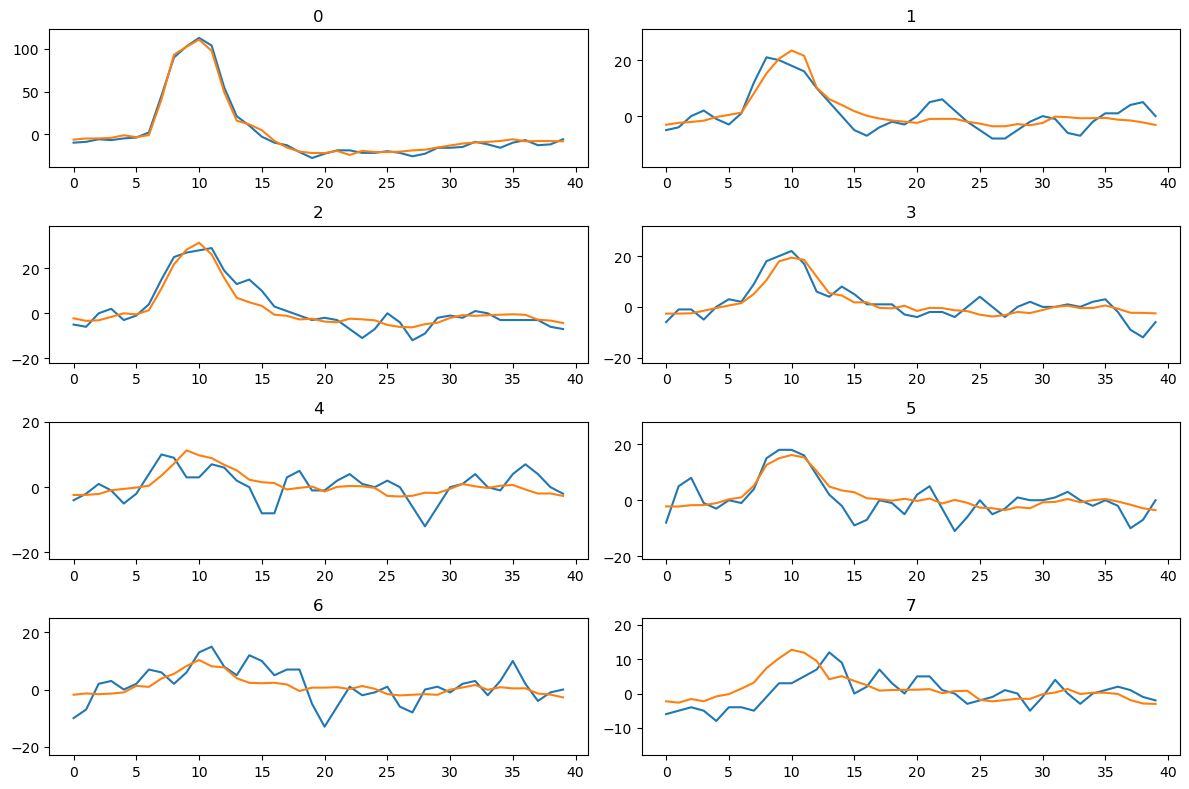

In [35]:
idx = 14
plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(imgs[idx, i])
    plt.plot(out[idx, i])
    plt.title(i); plt.ylim(imgs[idx, i].min()-10, imgs[idx, i].max()+10)
    
plt.tight_layout()

## Effect of Latent Dimensionality

In [ ]:
zdims = np.array([15, 20, 30])

learning_rate = 1e-3
num_epochs = 10

test_loss = np.zeros((zdims.shape[0], num_epochs))

for i in range(zdims.shape[0]):
    """
    Initialize the network and the Adam optimizer
    """
    net = CN_AE(zDim = zdims[i]).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    
    print("zDim = %d" % (zdims[i]))

    """
    Training the network for a given number of epochs
    The test loss after every epoch is saved
    """
    for epoch in range(num_epochs):
        print("Epoch %d" % (epoch))
        for idx, data in enumerate(train_loader, 0):
            print("\r" + str(idx), end="")
            imgs, _ = data
            imgs = imgs.to(device)

            # Feeding a batch of images into the network to obtain the output image
            out = net(imgs)
            loss = loss_fn(out, imgs)

            # Backpropagation based on the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # test error
        running_tloss = 0
        net.eval()
        with torch.no_grad():
            for idx, data in enumerate(test_loader):
                imgs, _ = data
                imgs = imgs.to(device)

                out = net(imgs)
                tloss = loss_fn(out, imgs)
                running_tloss += tloss

        test_loss[i, epoch] = running_tloss/(idx+1)
        print("\nLOSS | test %.4f" % (running_tloss/(idx+1)))

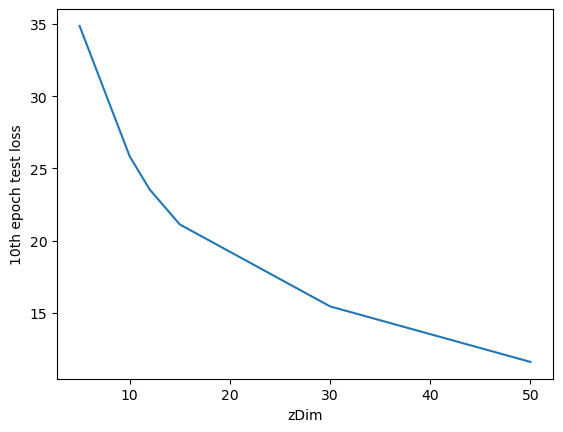

In [22]:
plt.plot(zdims, test_loss[:,9])
    
plt.ylabel("10th epoch test loss"); plt.xlabel("zDim");

## Linear Methods

In [ ]:
"""
Initialize Hyperparameters
"""
learning_rate = 1e-3
num_epochs = 10
lin_test_loss = np.zeros(10)

"""
Initialize the network and the Adam optimizer
"""
net = Lin_AE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    print('EPOCH %d' % (epoch))
    running_loss = 0
    last_loss = 0
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, _ = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out = net(imgs)
        loss = loss_fn(out, imgs)
        
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Gather data and report
        running_loss += loss
        if idx % 500 == 499:
            last_loss = running_loss/500
            print(" Batch %d | loss: %.4f" % (idx, last_loss))
            running_loss = 0
        
    print()
    # test error
    running_tloss = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            print("\r" + str(i), end="")
            imgs, _ = data
            imgs = imgs.to(device)
            
            out = net(imgs)
            tloss = loss_fn(out, imgs)
            running_tloss += tloss
        
    avg_vloss = running_tloss/(i+1)
    lin_test_loss[epoch] = avg_vloss
    
    print("\nLOSS | train: %.4f | test %.4f" % (last_loss, avg_vloss))

In [62]:
# convert datasets to numpy
train_loader = DataLoader(train_split, batch_size=len(train_loader.dataset), shuffle=True)
test_loader = DataLoader(test_split, batch_size=len(test_loader.dataset), shuffle=True)

for batch in train_loader:
    train_data = batch
    
for batch in test_loader:
    test_data = batch
    
train_data = np.array(train_data[0])
test_data = np.array(test_data[0])

In [68]:
train_data = train_data.reshape(-1, 320)
test_data = test_data.reshape(-1, 320)

In [69]:
train_data.shape

(160446, 320)

In [100]:
pca = PCA(n_components=15)
pca.fit(train_data)

PCA(n_components=15)

In [101]:
test_pca = pca.transform(test_data)
test_rec = pca.inverse_transform(test_pca)

In [102]:
test_rec = torch.from_numpy(test_rec)
# test_data = torch.from_numpy(test_data)

In [103]:
pca_loss = [int(loss_fn(test_rec, test_data))]

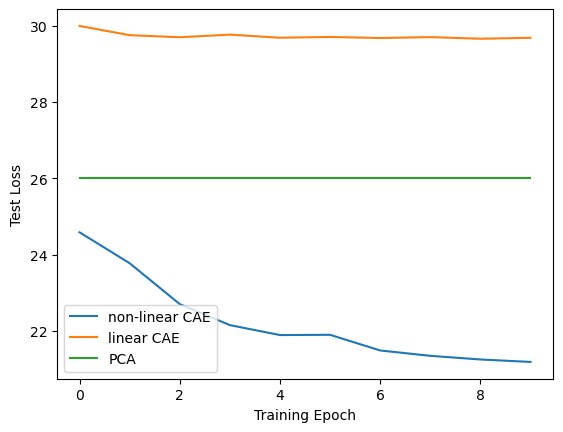

In [107]:
plt.plot(test_loss, label="non-linear CAE")
plt.plot(lin_test_loss, label="linear CAE")
plt.plot(pca_loss*10, label="PCA");
plt.legend(); plt.xlabel("Training Epoch"); plt.ylabel("Test Loss");
